In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [3]:
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [4]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

In [5]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [6]:
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Sandal  Sandal  Trouser  Sandal


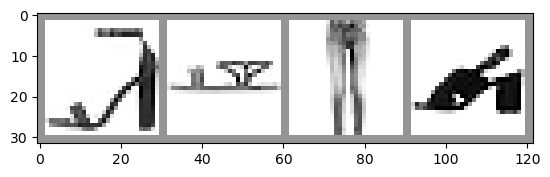

In [13]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap = "Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6 ,16 ,5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
model = GarmentClassifier()

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])
print(dummy_outputs)
print(dummy_labels)

tensor([[0.2114, 0.2184, 0.8512, 0.8810, 0.5981, 0.9778, 0.2493, 0.9013, 0.9915,
         0.7386],
        [0.0601, 0.1214, 0.6185, 0.6556, 0.8390, 0.0643, 0.6815, 0.7641, 0.7872,
         0.9962],
        [0.0229, 0.1714, 0.8490, 0.5496, 0.3947, 0.6601, 0.1766, 0.8051, 0.1382,
         0.4018],
        [0.0554, 0.5571, 0.2947, 0.3514, 0.9533, 0.7829, 0.8620, 0.0584, 0.7532,
         0.2166]])
tensor([1, 5, 3, 7])


In [28]:
loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

Total loss for this batch: 2.6571309566497803


In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [30]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    return last_loss

In [31]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.9788856257498264
  batch 2000 loss: 0.8467948801647872
  batch 3000 loss: 0.7157295617200434
  batch 4000 loss: 0.6586122044045478
  batch 5000 loss: 0.6041266018226743
  batch 6000 loss: 0.5730414411267266
  batch 7000 loss: 0.5474281007114332
  batch 8000 loss: 0.5022374506118358
  batch 9000 loss: 0.4916987164642196
  batch 10000 loss: 0.49446949050575495
  batch 11000 loss: 0.47700415970943866
  batch 12000 loss: 0.469417775003938
  batch 13000 loss: 0.4425571775601129
  batch 14000 loss: 0.45674926599580795
  batch 15000 loss: 0.4045581150105572
LOSS train 0.4045581150105572 valid 0.4340156316757202
EPOCH 2:
  batch 1000 loss: 0.40390229290068963
  batch 2000 loss: 0.3993991344135138
  batch 3000 loss: 0.3931060655856563
  batch 4000 loss: 0.3980762047492026
  batch 5000 loss: 0.38819020687567535
  batch 6000 loss: 0.3949922211659723
  batch 7000 loss: 0.37095255969784924
  batch 8000 loss: 0.3766471268375171
  batch 9000 loss: 0.3583166226508911
  ba

In [ ]:
# Modelin kaydedilmiş sürümünü yükleme
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))